In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from time import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.options.mode.chained_assignment= None #avoid unnecessary warnings

In [3]:
# Importing data

df= pd.read_csv('/content/drive/MyDrive/Deep Learning/Keras_FineTuner/train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Preprocessing

In [4]:
# 1. Excluding columns which have majority as null
df= df.loc[:, df.isnull().sum()/len(df)<0.80]

x= df.iloc[:, 1:-1] # Dropping 'Id' and the Y feature
y= df.iloc[:,-1]

train_cols= x.columns
print(df.shape, x.shape, y.shape)

(1460, 77) (1460, 75) (1460,)


In [5]:
# 2. Looking at the Overall statistics of variables and correlation among all variables
train_stats= x.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


<ipython-input-6-ce4c899a73a9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


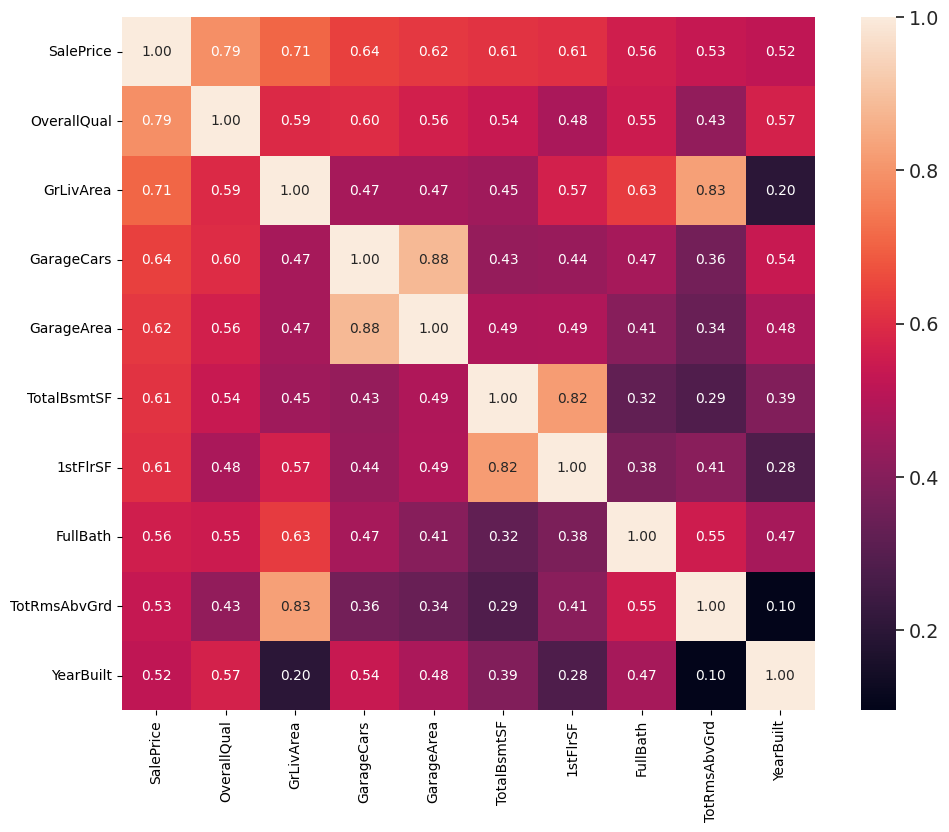

In [6]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True)

#saleprice correlation matrix
k=10
cols= corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm= np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm= sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size':10},
                yticklabels=cols.values,
                xticklabels=cols.values)
plt.show()
# Conclusion: OverallQual is highly correlated with the target variable.

3. Division of different column type for different preprocessing and division between the train and test datasets

In [7]:
ordinal_cols= list(x.columns[x.columns.str.contains('Yr|Year')])
print('ordinal/temporal columns:\n',ordinal_cols)
nominal_cols= list(set(x.select_dtypes(include=['object']).columns)- set(ordinal_cols))
print('nominal columns:\n', nominal_cols)
numeric_cols= list(set(x.select_dtypes(exclude=['object']).columns)- set(ordinal_cols))
print('numeric columns:\n',numeric_cols)

ordinal/temporal columns:
 ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
nominal columns:
 ['LotShape', 'MSZoning', 'PavedDrive', 'GarageCond', 'Heating', 'LandSlope', 'LandContour', 'Condition2', 'BsmtCond', 'SaleCondition', 'RoofMatl', 'MasVnrType', 'ExterQual', 'GarageFinish', 'Exterior2nd', 'BsmtQual', 'HouseStyle', 'Neighborhood', 'Exterior1st', 'ExterCond', 'BsmtFinType1', 'Electrical', 'GarageType', 'FireplaceQu', 'SaleType', 'Condition1', 'Functional', 'CentralAir', 'RoofStyle', 'Foundation', 'KitchenQual', 'GarageQual', 'Street', 'BsmtExposure', 'LotConfig', 'BldgType', 'HeatingQC', 'BsmtFinType2', 'Utilities']
numeric columns:
 ['OverallCond', '1stFlrSF', 'GarageCars', 'LowQualFinSF', 'EnclosedPorch', 'MSSubClass', 'LotArea', '3SsnPorch', 'BsmtFinSF2', 'LotFrontage', 'GrLivArea', 'MiscVal', 'TotalBsmtSF', 'BsmtFinSF1', 'Fireplaces', 'BsmtFullBath', 'KitchenAbvGr', 'GarageArea', 'HalfBath', 'BedroomAbvGr', 'OpenPorchSF', 'TotRmsAbvGrd', 'OverallQual', 'FullBath', '2nd

In [ ]:
# Checking unique values
x[nominal_cols].describe().transpose()

In [10]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.20, random_state=0)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1168, 75), (292, 75), (1168,), (292,))

4. Missing Value Imputation

Performing simple imputation as the goal of this exercise is to focus on improvement using KerasTuner.

In [11]:
def missing_val_imputation(x, ordinal_cols,nominal_cols,numeric_cols):
    
    for col in ordinal_cols:
        x.loc[:,col]= x.loc[:,col].fillna(x.loc[:,col].mean())

    x.loc[:,nominal_cols]= x.loc[:,nominal_cols].fillna("?")
    
    for col in numeric_cols:
        x.loc[:,col]= x.loc[:,col].fillna(x.loc[:,col].mean())
#         x.loc[:,col]= x.groupby("OverallQual")[col].transform(lambda grp:grp.fillna(np.mean(grp)))

    print("All missing values are now imputed!\n",x.isnull().sum().sort_values(ascending=False))
    
    return x

In [12]:
x_train= missing_val_imputation(x_train,ordinal_cols,nominal_cols,numeric_cols)
x_test= missing_val_imputation(x_test,ordinal_cols,nominal_cols,numeric_cols)

All missing values are now imputed!
 MSSubClass       0
GarageType       0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 75, dtype: int64
All missing values are now imputed!
 MSSubClass       0
GarageType       0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 75, dtype: int64


5. Analysis and treatment of temporal variables

Strategy- capture time difference from YearSold

In [13]:
# Fitting OHE object
ohe= OneHotEncoder(handle_unknown='ignore', sparse=False).fit(x_train[nominal_cols]) 

#Feature Encoding for nominal columns

def ohe_transform(x, ohe, nominal_cols):
    x_ohe= pd.DataFrame(ohe.transform(x[nominal_cols]))
    x_ohe.columns=ohe.get_feature_names_out(nominal_cols)

    # prepping x
    x=x.drop(nominal_cols, axis=1)
    x.reset_index(inplace=True, drop=True)
    x= x.merge(x_ohe, left_index=True, right_index=True)
    
    return x

x_train= ohe_transform(x_train, ohe, nominal_cols)
x_test= ohe_transform(x_test, ohe, nominal_cols)
x_train.shape, x_test.shape

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((1168, 283), (292, 283))

In [14]:
# Standard Scaling
ss= StandardScaler()
x_train_ss= pd.DataFrame(ss.fit_transform(x_train))
x_test_ss= pd.DataFrame(ss.transform(x_test))
x_train.shape, x_train_ss.shape, x_test_ss.shape, y_train.shape

((1168, 283), (1168, 283), (292, 283), (1168,))

## Feature Selection

In [15]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

sel= SelectFromModel(Lasso(alpha=0.5, max_iter=3000, tol=0.005, random_state=0, warm_start= False)) # warm_start= True

# train the lasso model and select features
sel.fit(x_train_ss, y_train)

sel.get_support()

selected_feats= x_train_ss.columns[(sel.get_support())]

# print the stats
print("# of total features: ",x_train.shape[1])
print("# of selected features: ",len(selected_feats))
# print("# of rejected features: ",np.sum(sel.estimator_.coef_==0))
# print('Selected features:', selected_feats)

x_train_ss= x_train_ss[selected_feats]
x_test_ss= x_test_ss[selected_feats]

x_train_ss.shape, x_test_ss.shape

# of total features:  283
# of selected features:  258


((1168, 258), (292, 258))

In [25]:
# Setting up a baseline model

logreg= LogisticRegression(random_state=3, max_iter=150, warm_start=True, n_jobs=-1)

logreg.fit(x_train_ss, y_train)

y_pred_logreg= logreg.predict(x_test_ss)
y_pred_logreg_train= logreg.predict(x_train_ss)

print("Training score:",r2_score(y_train, y_pred_logreg_train))
# Model Accuracy

print("Test score:",r2_score(y_test,y_pred_logreg))
print("Mean squared error: ",np.sqrt(mean_squared_error(y_test, y_pred_logreg))) 

# Big time overfitting however our 

Training score: 0.999989953179032
Test score: 0.3358969882991998
Mean squared error:  67721.45715686152


## Implemention of Neural network

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


print(tf.__version__)

2.12.0


In [27]:
# Building a simple neural network

def build_model():
    model=keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(x_train_ss.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    #No activation is used in the last layer as this is regression
    optimizer= tf.keras.optimizers.Adam(0.001)
    
    model.compile(loss='mse',
                 optimizer= optimizer,
                 metrics= ['mae', 'mse'])
    return model

In [28]:
# Build and inspect the model

model= build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               33152     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43,521
Trainable params: 43,521
Non-trainable params: 0
_________________________________________________________________


## Train the model

Train the model for 500 epochs, and record the training and validation accuracy in the history object

In [29]:
# Setting 'restore_best_weights' as True helps restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history= model.fit(
    x_train_ss, y_train,
    epochs=200,
    validation_data=(x_test_ss, y_test),
    verbose=0, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= model.evaluate(x_test_ss, y_test, verbose=1)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

Epoch 60: early stopping
10/10 [==============================] - 0s 3ms/step - loss: 3663589376.0000 - mae: 29803.6602 - mse: 3663589376.0000
Test-set Mean absolute error: 29803.66


Text(0.5, 1.0, 'Train - MAE')

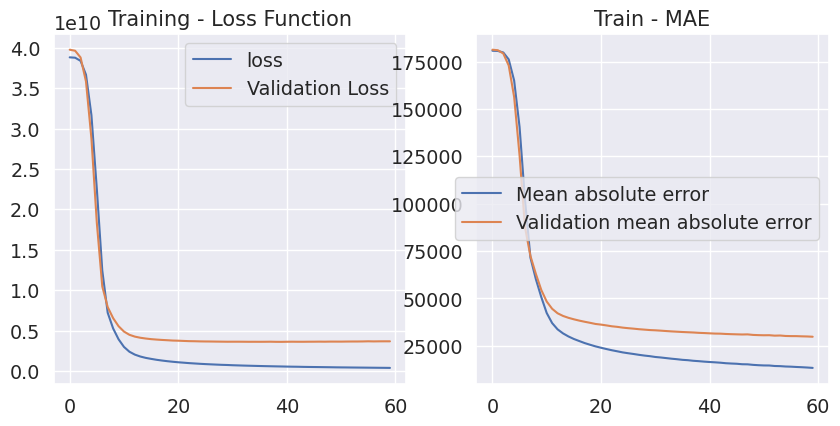

In [30]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Mean absolute error')
plt.plot(history.history['val_mae'], label='Validation mean absolute error')
plt.legend()
plt.title('Train - MAE')

Visualize the model's training progress using the stats stored in the history object

10/10 [==============================] - 0s 4ms/step


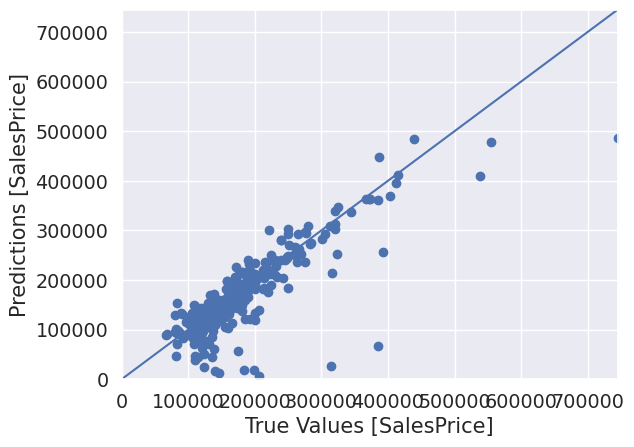

In [31]:
y_pred_test= model.predict(x_test_ss).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [SalesPrice]')
plt.ylabel('Predictions [SalesPrice]')

lims=[0, max(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#### It looks like our model predicts reasonably well. Let's take a look at the error distribution.

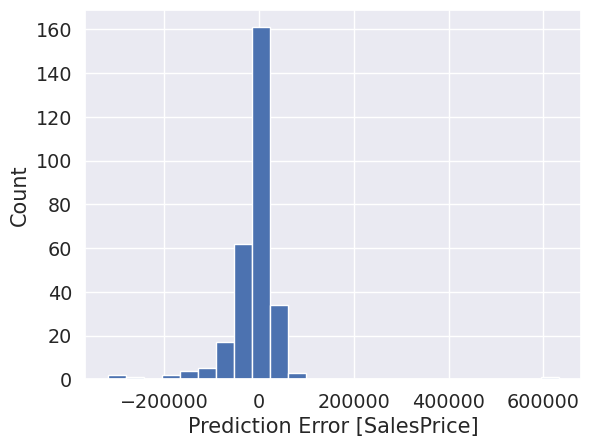

In [32]:
error= y_pred_test-y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SalesPrice]')
_=plt.ylabel('Count')

#### It's not quite gaussian, but we might expect that because the number of samples is very small.

In [33]:
# Accuracy metrics :

y_pred_train= model.predict(x_train_ss).flatten()

print("Accuracy obtained using x_train and x_val sets from the original x!")

print("Training accuracy: ",r2_score(y_train, y_pred_train))

print("Test accuracy: ",r2_score(y_test, y_pred_test))

print("Test mean-squared error: ",np.sqrt(mean_squared_error(y_test, y_pred_test)))

#Hence the current test accuracy is 0.48385 and Test MSE is 59703.04
# Note- adding a droput layer decreases the accuracy to 0.46

37/37 [==============================] - 0s 2ms/step
Accuracy obtained using x_train and x_val sets from the original x!
Training accuracy:  0.9411143284110148
Test accuracy:  0.4694947649204918
Test mean-squared error:  60527.59336515474


### Optimizing Neural networks through KerasTuner


In [35]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband
import IPython

<ipython-input-36-d95362518485>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


#### 1. Define the model for hypertuning

In [37]:
class ANNhypermodel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
        model.add(keras.layers.Dense(1))

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape= [len(x_train_ss.keys())])

In [38]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='houseprices',
                   overwrite=True)

# tuner.search_space_summary()

In [39]:
print('searching for the best params!')

t0= time()
tuner.search(x= x_train_ss,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (x_test_ss, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!
2190.58256649971  secs


In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')}  

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(x_test_ss, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 160,
second layer is 128 
third layer is 64  

and the optimal learning rate for the optimizer
is 0.0013653501948374237.

[]
10/10 [==============================] - 0s 3ms/step - loss: 3288080640.0000 - mae: 30548.4629 - mse: 3288080640.0000
loss:3288080640.0 mae: 30548.462890625 mse: 3288080640.0


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
tuned_model = tuner.hypermodel.build(best_hps)

# Check result using best model
t00= time()
history_tuned= tuned_model.fit(x_train_ss, y_train, 
          epochs = 200, 
          validation_data = (x_test_ss, y_test),
          verbose=0,
          callbacks= early_stopping_cb)

# print(time()- t00," secs")

print("\n Using Early stopping, needed only ",len(history_tuned.history['val_mse']),"epochs to converge!")

Epoch 47: early stopping

 Using Early stopping, needed only  47 epochs to converge!


In [ ]:
y_pred_train_tuned= tuned_model.predict(x_train_ss).flatten()
y_pred_test_tuned= tuned_model.predict(x_test_ss).flatten()

print("Training accuracy: ",r2_score(y_train, y_pred_train_tuned))

print("Test accuracy: ",r2_score(y_test, y_pred_test_tuned))

print("Test mean-squared error: ",np.sqrt(mean_squared_error(y_test, y_pred_test_tuned)))

10/10 [==============================] - 0s 2ms/step
Training accuracy:  0.9658177843345666
Test accuracy:  0.4691418677165572
Test mean-squared error:  60547.72178802943
